Attempt using the Vgg network without resizing images. 

Data Augmentation with fill_mode='nearest', to discover differences in performance w.r.t. fill_mode='constant'.

Dataset: 1900 Tomatoes, 2x Raspberry.

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### **LIBRERIE**

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [ ]:
#Extracting the zipped archive into the folder in which I am 

!unzip ../gdrive/MyDrive/Challenge1_Mio/Vgg16/vgg16_dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resnet_dataset/train/Blueberry/01924.jpg  
  inflating: resnet_dataset/train/Blueberry/02066.jpg  
  inflating: resnet_dataset/train/Blueberry/01936.jpg  
  inflating: resnet_dataset/train/Blueberry/01909.jpg  
  inflating: resnet_dataset/train/Blueberry/01697.jpg  
  inflating: resnet_dataset/train/Blueberry/02074.jpg  
  inflating: resnet_dataset/train/Blueberry/02140.jpg  
  inflating: resnet_dataset/train/Blueberry/02183.jpg  
  inflating: resnet_dataset/train/Blueberry/02188.jpg  
  inflating: resnet_dataset/train/Blueberry/02093.jpg  
  inflating: resnet_dataset/train/Blueberry/02225.jpg  
  inflating: resnet_dataset/train/Blueberry/01889.jpg  
  inflating: resnet_dataset/train/Blueberry/02223.jpg  
  inflating: resnet_dataset/train/Blueberry/01781.jpg  
  inflating: resnet_dataset/train/Blueberry/01668.jpg  
  inflating: resnet_dataset/train/Blueberry/02147.jpg  
  inflating: resnet_dataset/train/Blueberry/01786.jpg 

### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#**DATASET**

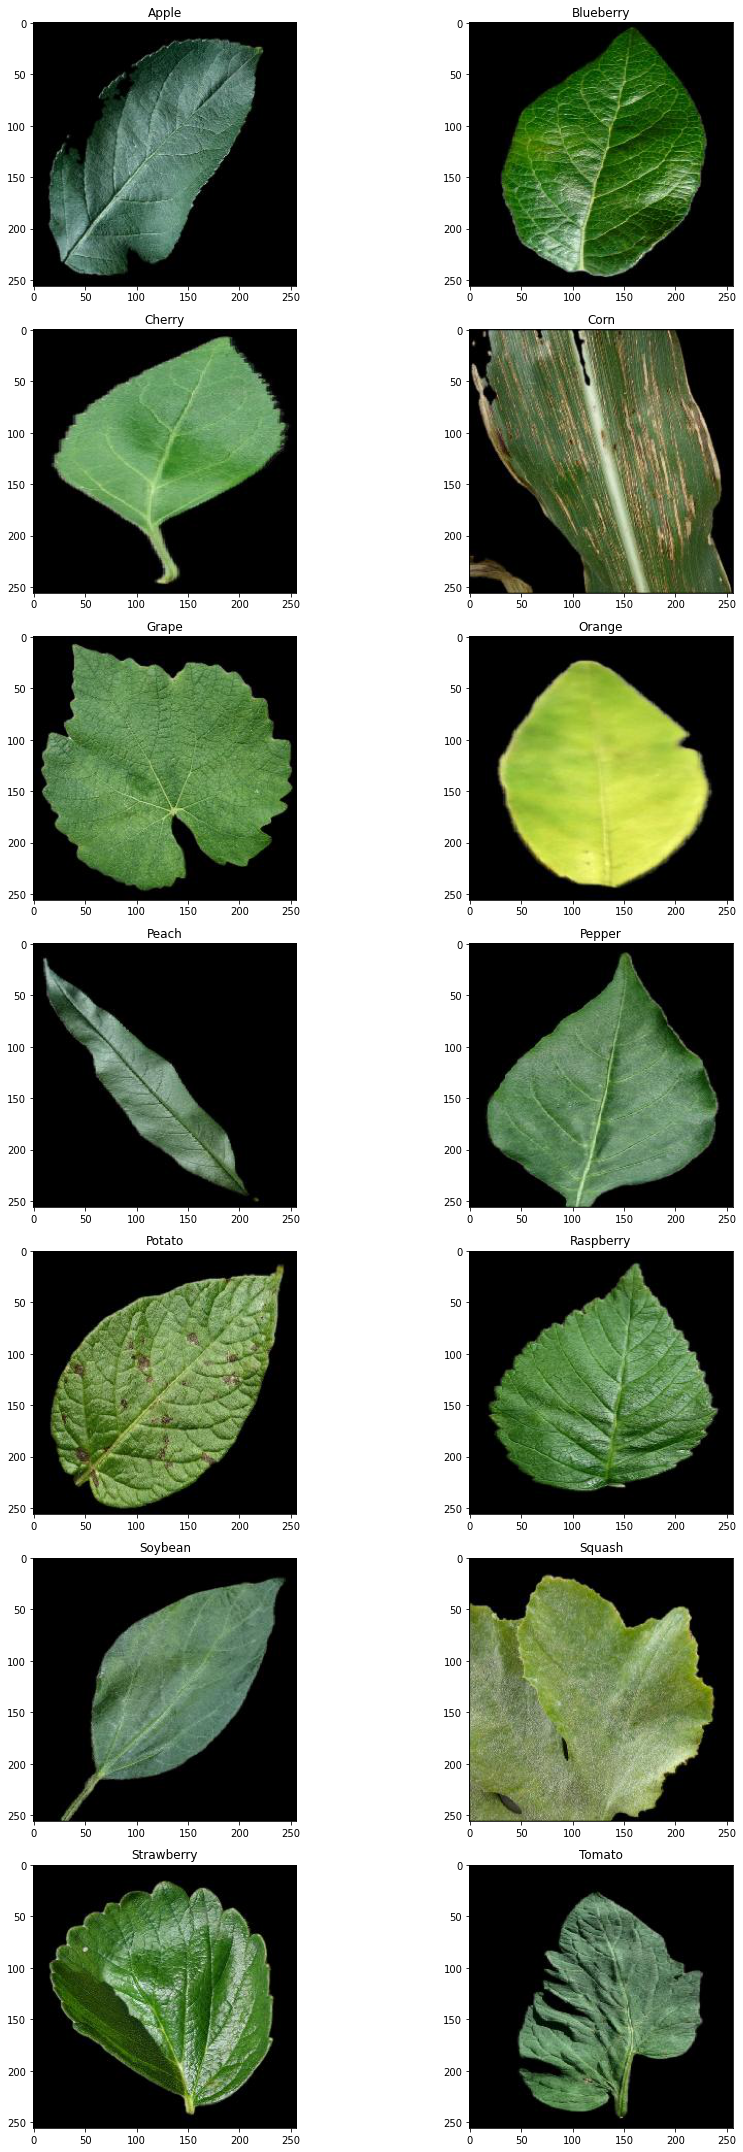

In [ ]:
dataset_dir = 'resnet_dataset' 

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') 

# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Number of training images per category:')

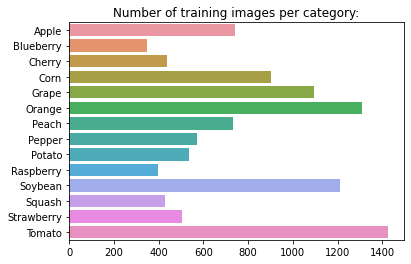

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

# **SHOW EXAMPLE IMAGE**

In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

###**DATA AUGMENTATION**

**SETS**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=150,
                                        width_shift_range=200,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=False, 
                                        fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [ ]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 10645 images belonging to 14 classes.
Found 2124 images belonging to 14 classes.
Found 1430 images belonging to 14 classes.


(Input) image shape: (32, 256, 256, 3)
Target shape: (32, 14)

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Apple


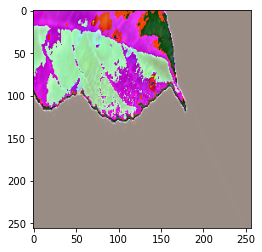

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

#**CALLBACKS**

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('../gdrive/MyDrive/Challenge1_Mio/Vgg16/Checkpts/Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

### **Transfer learning**

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

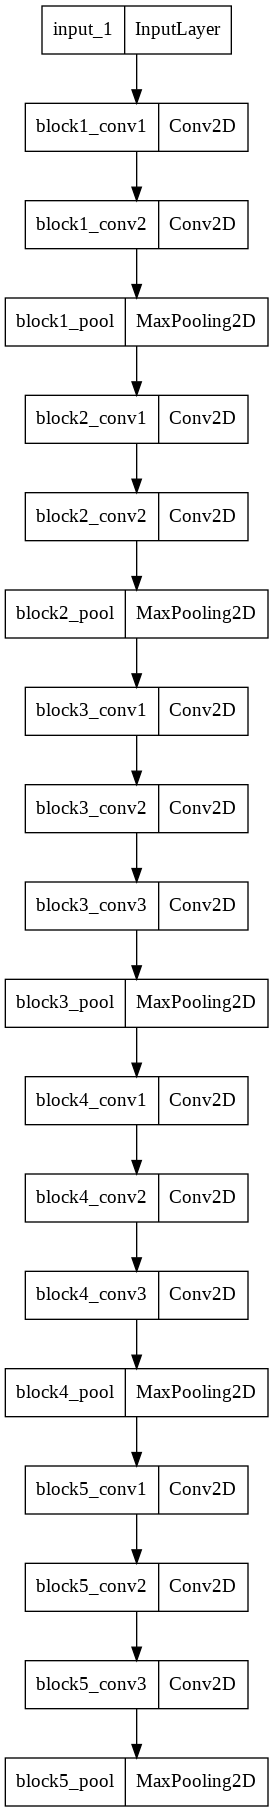

In [ ]:

# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)


### Models metadata

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

In [ ]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 14)                3598  

In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
).history

Epoch 1/200
333/333 [==============================] - 180s 527ms/step - loss: 2.9536 - accuracy: 0.3186 - precision_3: 0.5481 - recall_3: 0.1803 - val_loss: 1.1858 - val_accuracy: 0.6163 - val_precision_3: 0.8316 - val_recall_3: 0.4859
Epoch 2/200
333/333 [==============================] - 198s 594ms/step - loss: 1.8655 - accuracy: 0.4209 - precision_3: 0.7343 - recall_3: 0.2645 - val_loss: 0.9164 - val_accuracy: 0.6911 - val_precision_3: 0.8851 - val_recall_3: 0.5913
Epoch 3/200
333/333 [==============================] - 172s 516ms/step - loss: 1.6829 - accuracy: 0.4738 - precision_3: 0.7617 - recall_3: 0.3318 - val_loss: 0.8365 - val_accuracy: 0.7133 - val_precision_3: 0.8710 - val_recall_3: 0.6262
Epoch 4/200
333/333 [==============================] - 177s 531ms/step - loss: 1.5509 - accuracy: 0.5027 - precision_3: 0.7768 - recall_3: 0.3613 - val_loss: 0.6955 - val_accuracy: 0.7655 - val_precision_3: 0.8876 - val_recall_3: 0.6766
Epoch 5/200
333/333 [==============================]

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
%cd /gdrive/MyDrive/Challenge1_Mio/Vgg16

/gdrive/MyDrive/Challenge1_Mio/Vgg16


In [ ]:
# Save the best model
tl_model.save('FineFineTuning_v1')
# del tl_model  # To avoid filling the memory

INFO:tensorflow:Assets written to: FineFineTuning_v1/assets


# **FINE TUNING**

In [ ]:
%cd /gdrive/MyDrive/Challenge1_Mio/Vgg16

/gdrive/MyDrive/Challenge1_Mio/Vgg16


In [ ]:
# Re-load the model after transfer learning
tl_model = tfk.models.load_model('FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 32768)             0         
                                                                 
 dropout_12 (Dropout)        (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 Output (Dense)              (None, 14)                3598  

In [ ]:
%cd /content

/content


In [ ]:
# Set all VGG layers to True
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_11 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_11 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 32768)             0         
                                                                 
 dropout_12 (Dropout)        (None, 32768)             0      

In [ ]:
# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)]
).history

Epoch 1/200
333/333 [==============================] - 168s 505ms/step - loss: 1.2624 - accuracy: 0.6071 - precision_4: 0.8235 - recall_4: 0.4797 - val_loss: 0.2610 - val_accuracy: 0.9120 - val_precision_4: 0.9477 - val_recall_4: 0.8879
Epoch 2/200
333/333 [==============================] - 169s 508ms/step - loss: 0.9560 - accuracy: 0.7046 - precision_4: 0.8721 - recall_4: 0.5913 - val_loss: 0.2527 - val_accuracy: 0.9124 - val_precision_4: 0.9437 - val_recall_4: 0.8847
Epoch 3/200
333/333 [==============================] - 165s 496ms/step - loss: 0.8561 - accuracy: 0.7328 - precision_4: 0.8899 - recall_4: 0.6365 - val_loss: 0.2604 - val_accuracy: 0.9322 - val_precision_4: 0.9424 - val_recall_4: 0.9242
Epoch 4/200
333/333 [==============================] - 167s 501ms/step - loss: 0.7530 - accuracy: 0.7663 - precision_4: 0.9022 - recall_4: 0.6797 - val_loss: 0.1546 - val_accuracy: 0.9468 - val_precision_4: 0.9559 - val_recall_4: 0.9379
Epoch 5/200
333/333 [==============================]

In [ ]:
%cd ../gdrive/MyDrive/Challenge1_Mio/Vgg16

/gdrive/MyDrive/Challenge1_Mio/Vgg16


In [ ]:
#Save the best model
tl_model.save('Tuned_v1_1')

INFO:tensorflow:Assets written to: Tuned_v1_1/assets


In [ ]:
%cd /content

/content


# Test model on test set

In [ ]:

# Test the model
tl_model = tfk.models.load_model("../gdrive/MyDrive/Challenge1_Mio/Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)


45/45 [==============================] - 5s 101ms/step - loss: 0.0328 - accuracy: 0.9951 - precision_4: 0.9958 - recall_4: 0.9944

Test metrics
{'loss': 0.03284381330013275, 'accuracy': 0.9951049089431763, 'precision_4': 0.9957982897758484, 'recall_4': 0.9944055676460266}
